In [1]:
from worm_wiring import worm_wiring
import pandas as pd
import networkx as nx
import numpy as np

In [2]:
# adjacency matrix, rows presynaptic, cols post synaptic
struct = {'structure': "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvMTY5NjIvZWxpZmUtMTY5NjItZmlnMTYtZGF0YTEtdjEueGxzeA--/elife-16962-fig16-data1-v1.xlsx?_hash=ltleHMu0Mu0ujKuGWUeIsAsFtqARmr7badHc8RYWqcA%3D"}

# cell type, characteristics, of cells, Annotation(e.g. sensory, inter, motor)
# annoyingly, doesn't list ids in adj. must infer, e.g. in Abreviation is PR-I,
# and there are 10 cells of this, then matching ids will pr
base_atts = {'basic_atts': "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvMTY5NjIvZWxpZmUtMTY5NjItZmlnMS1kYXRhMS12MS54bHN4/elife-16962-fig1-data1-v1.xlsx?_hash=RJKemxiTOb3fYQn5SXeog7w8Lzn%2F9Cka4BwHFyruMaM%3D"}

# Neurons with synapses having mixed electron-lucent and dense-core vesicle populations (mixed), or exclusively
# dense-core vesicle (dcv) populations, with numbers (No.) of synapses of each type, and totals of both dcv and
# mixed vesicle synapses.
ves_data = {'vesicle_data': "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvMTY5NjIvZWxpZmUtMTY5NjItZmlnMi1kYXRhMS12MS54bHN4/elife-16962-fig2-data1-v1.xlsx?_hash=SUBi7L6RxZ6F6hJIT0vzbm2E7xon08LVP4IaNB4RJhM%3D"}

# Neurons listed by ID, with cell type, morphological features, location, presence or absence of cilia, and number
# of each neuron’s pre- and postsynaptic sites or putative gap junctions (>0.06 µm). Ependymal cells excluded. The
# final column shows left lateral views of individual neuron reconstructions (whole cells, or terminals for
# photoreceptors) as small thumbnails with scale bars: 1 µm (thick bars: coronet cells, lens cells, photoreceptor
# terminals and PR-III cells, vacINs); 10 µm (thin bars: all other cells).
cell_data = {'cell_bio_data': "https://elifesciences.org/download/aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5vcmcvYXJ0aWNsZXMvMTY5NjIvZWxpZmUtMTY5NjItZmlnMy1kYXRhMS12MS54bHN4/elife-16962-fig3-data1-v1.xlsx?_hash=PIvd%2FA8L6avkM1Y3ebK9%2BlgoGGiskaH53PsAYK%2BtGyM%3D"}


In [3]:
files = {**struct, **base_atts, **ves_data, **cell_data}
dfs = {f: worm_wiring.pull_xl_file(files[f]) for f in files}
print('Got excel data')


Got excel data


In [4]:
dfs['structure'][0].head()

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,NaN,pns1,pns10,pns11,pns12,pns13,pns14,pns2,pns3,pns4,...,BTN2,BTN3,BTN4,mul,mulm,mur,murm,bm,bm-noto,Total
1,pns1,NaN,NaN,NaN,NaN,0.96,NaN,NaN,0.12,0.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24,NaN,4.38
2,pns10,0.66,NaN,1.62,0.72,0.12,NaN,NaN,0.9,1.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.98
3,pns11,NaN,0.42,NaN,0.18,NaN,NaN,NaN,0.24,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.19
4,pns12,0.12,1.02,0.24,NaN,0.54,NaN,NaN,1.02,0.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.78


In [4]:
dfs['basic_atts'][0].head()

,0,1,2,3,4,5,6,7
0,Abbreviation,Colour,Cell Type,Characteristics,Subtypes,Number of cells,Cell IDs,Annotation
1,PR-I,NaN,Type I Photoreceptors,Outer segments into ocellus pigment,"(osa, osd, osp: outer segments project to ante...",23,pr1-pr23,Sensory
2,PR-II,NaN,Type II Photoreceptors,Outer segments directly into neural canal near...,"(osa, osd, osp: outer segments project to ante...",7,pra-prg,Sensory
3,PR-III,NaN,Type III Photoreceptors,Ventral vacuolated cells between Cor and lens ...,-,6,"lens6-7, 84, 101, 110, 113, 114",Sensory
4,Lens,,Lens cells,"Large, vacuolated cells ventral to ocellus pig...",-,3,"lens4, lens5, lens8",Accessory


In [5]:
adj = dfs['structure'][0]
col_labels = list(adj.iloc[0, :])
row_labels = list(adj.iloc[:, 0])
col_labels = [l for l in col_labels]
col_lab_set = set(col_labels)
row_labels = {l for l in row_labels}
joint_labels = col_lab_set.intersection(row_labels)

In [6]:
# process the structure
adj.columns = col_labels
selected_cols = adj[list(joint_labels)]
common_adj = selected_cols.loc[selected_cols[np.nan].isin(joint_labels)]
np_adj = common_adj.values
integerized = np_adj[1:, 1:].astype(np.float64)
graph = nx.from_numpy_array(integerized, create_using=nx.DiGraph)
print('got adj to nx')

got adj to nx


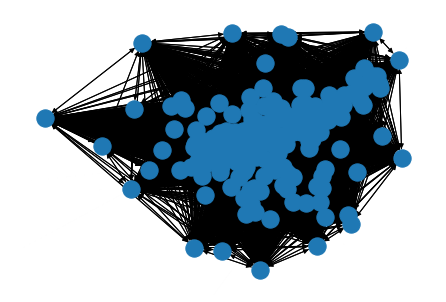

In [7]:
nx.draw(graph)
